In [1]:
import albumentations as album

C:\Users\lockd\anaconda3\envs\pyTest\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lockd\anaconda3\envs\pyTest\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\lockd\anaconda3\envs\pyTest\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [3]:
import segmentation_models_pytorch as smp

In [4]:
DATA_PATH = "tiff/"
x_train_dir = os.path.join(DATA_PATH,"train")
y_train_dir = os.path.join(DATA_PATH,"train_labels")

x_valid_dir = os.path.join(DATA_PATH,"val")
y_valid_dir = os.path.join(DATA_PATH,"val_labels")

x_test_dir = os.path.join(DATA_PATH,"test")
y_test_dir = os.path.join(DATA_PATH,"test_labels")

In [5]:
class_dict = pd.read_csv("label_class_dict.csv")
#클래스 이름 가져오기
class_names = class_dict['name'].tolist()
#클래스 RGB값 가져오기
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names : ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names :  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [6]:
# 클래스 수가 많은 데이터 세트의 특정 클래스를 요약하는 데 유용
select_classes = ['background', 'building']

# RGB 값 가져오기
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [37]:
# 데이터 시각화를 위한 함수
def visualize(**images):
    """
    한 행에 플롯 이미지
    """
    n_images = len(images)
    plt.figure(figsize = (20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        #파라미터 이름에서 제목 가져오기
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()
    
#라벨에 원 핫 인코딩을 수행
def one_hot_encode(label, label_values):
    """
    분할 영상 레이블 배열을 원 핫 형식으로 변환
    각 픽셀 값을 길이 num_의 벡터로 대체
    # Arguments (인자)
    label : 2D 배열 분할 영상 레이블
    label_values

    # returns
    num_class의 깊이를 갖는 입력과 동일한 폭과 높이를 갖는 2D 배열
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

#labels와 예측에 역 원핫인코딩 수행
def reverse_one_hot(image):
    """
    원-핫 형식(깊이는 num_classes)의 2D 배열을 
    각 픽셀 값이 분류된 클래스 키인 1 채널만 있는 2D 배열로 변환.
    # Argments
    image : one-hot 포맷 이미지

    # returns
    입력과 동일한 너비와 높이이지만 깊이 크기가 1인 2D 배열. 
    여기서 각 픽셀 값은 분류된 클래스 키.
    """
    x = np.argmax(image, axis = -1)
    return x

# 역 원핫인코딩의 결과에 컬러코딩 수행
def colour_code_segmentation(image, label_values):
    """
    클래스 키의 1채널 배열이 주어지면 분할 결과를 컬러 코드화.
    # Argument
    image: 각 값이 클래스 키를 나타내는 단일 채널 배열
    label_values

    # 리턴즈
    분할 시각화를 위해 색상 부호화된 영상
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [53]:
class BuildingsDataset(torch.utils.data.Dataset):
    """
    메사추세츠 빌딩 데이터 세트. 
    이미지를 읽고, 확대 및 전처리 변환.

    args:
    images_dir: images 폴더
    masks_dir : 분할 마스크 폴더 
    class_rgb_values (list) : 분할 마스크에서 추출할 선택 클래스의 RGB 값
    augmentation (alummentations.Compose): 데이터 변환 파이프라인(예: 플립, 스케일 등)
    전처리(alummentations.composition): 데이터 전처리(정규화, 차원조작 등)
    """
    
    def __init__(
        self,
        images_dir,
        masks_dir,
        class_rgb_values=None,
        augmentation = None,
        preprocessing=None,
    ):
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        #이미지와 마스크를 읽는다
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        #마스크 원핫인코드
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float32')
        
        #증강 적용
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image,mask = sample['image'],sample['mask']
            
        #전처리 적용
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image,mask = sample['image'], sample['mask']
            
        return image, mask
    
    def __len__(self):
        #return length of
        return len(self.image_paths)

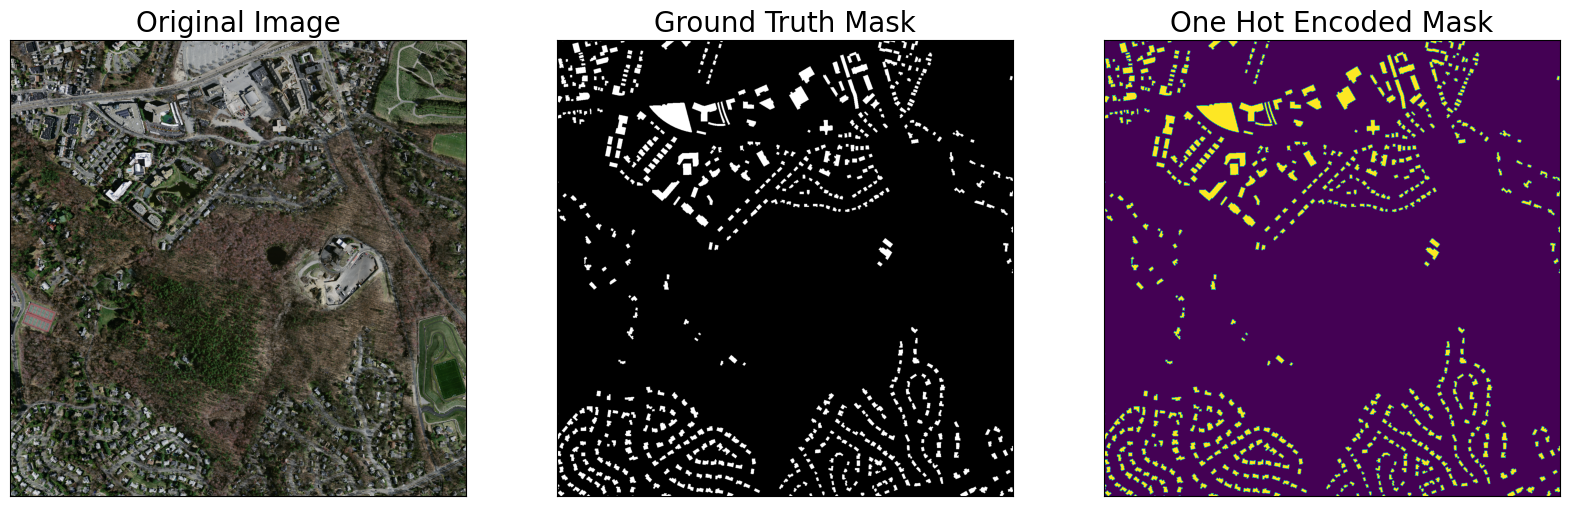

In [54]:
### 샘플 이미지와 마스크 시각화
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [64]:
# Augmentation 정의
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    #이미지가 32개로 나뉘도록 충분한 패딩을 더한다
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2,0,1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """
    전처리 변환 구성
    인자:
    preprocessing_fn(callable) : 데이터 정규화 함수
        (각 사전 훈련된 신경망에 따라 특정될 수 있음)
    return:
        transform: albumentations.Compose
    """
    
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

### 증가 이미지 & 마스크 시각화

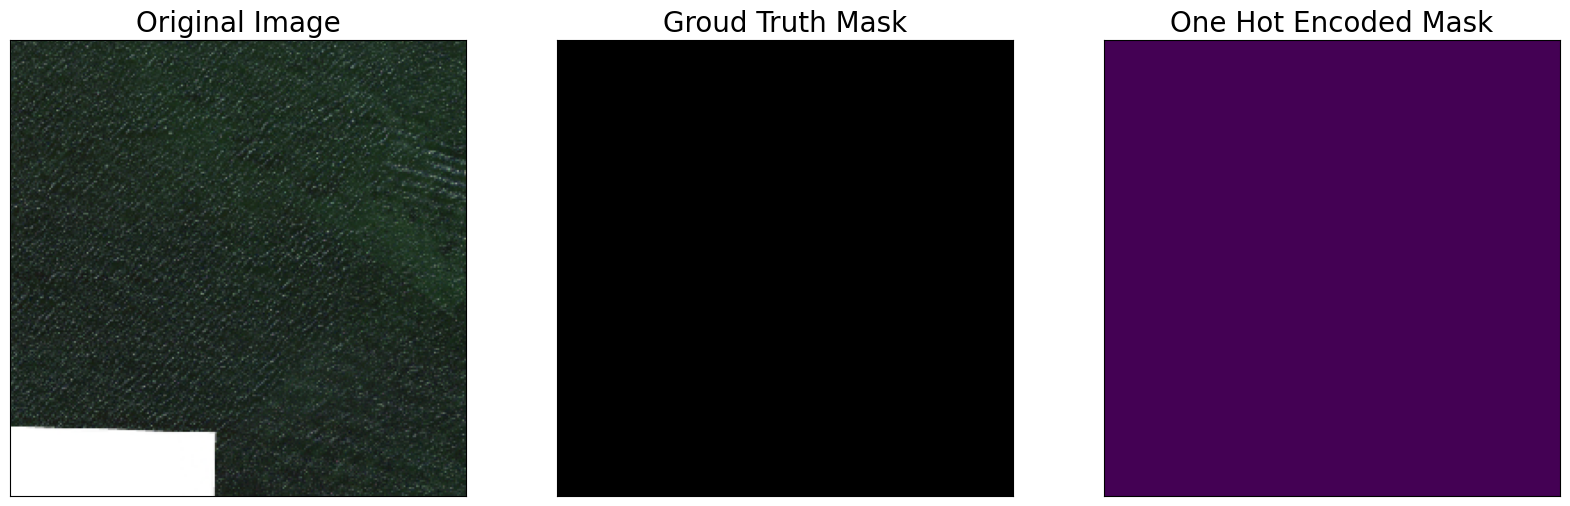

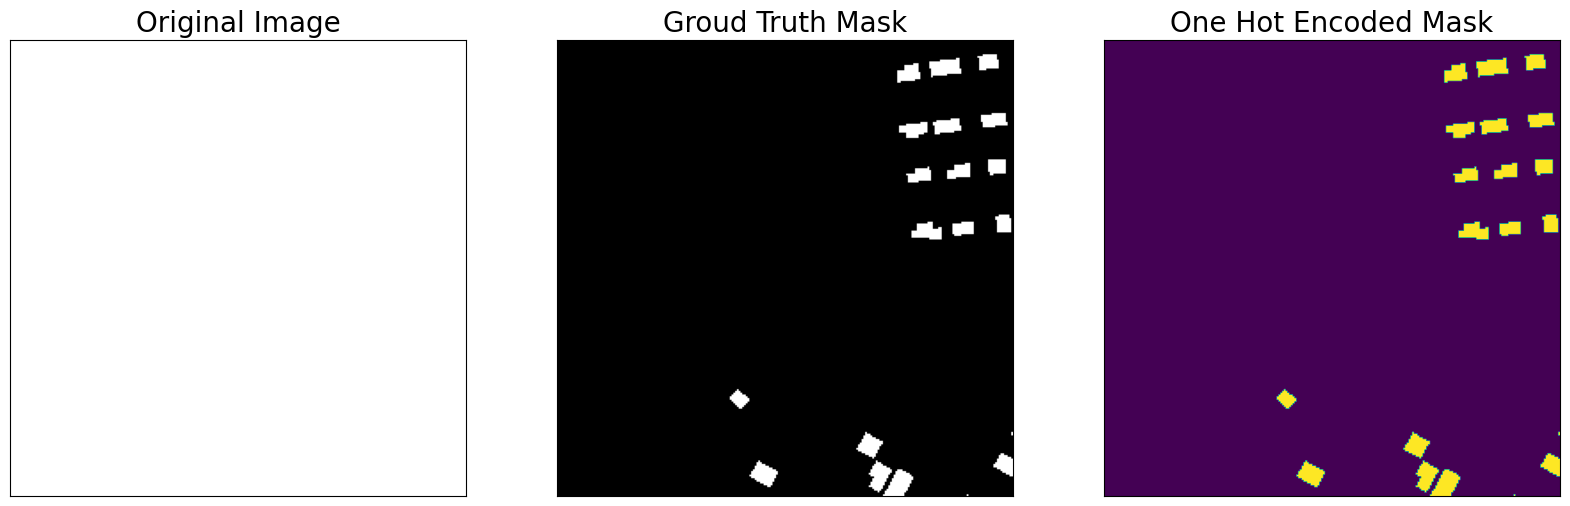

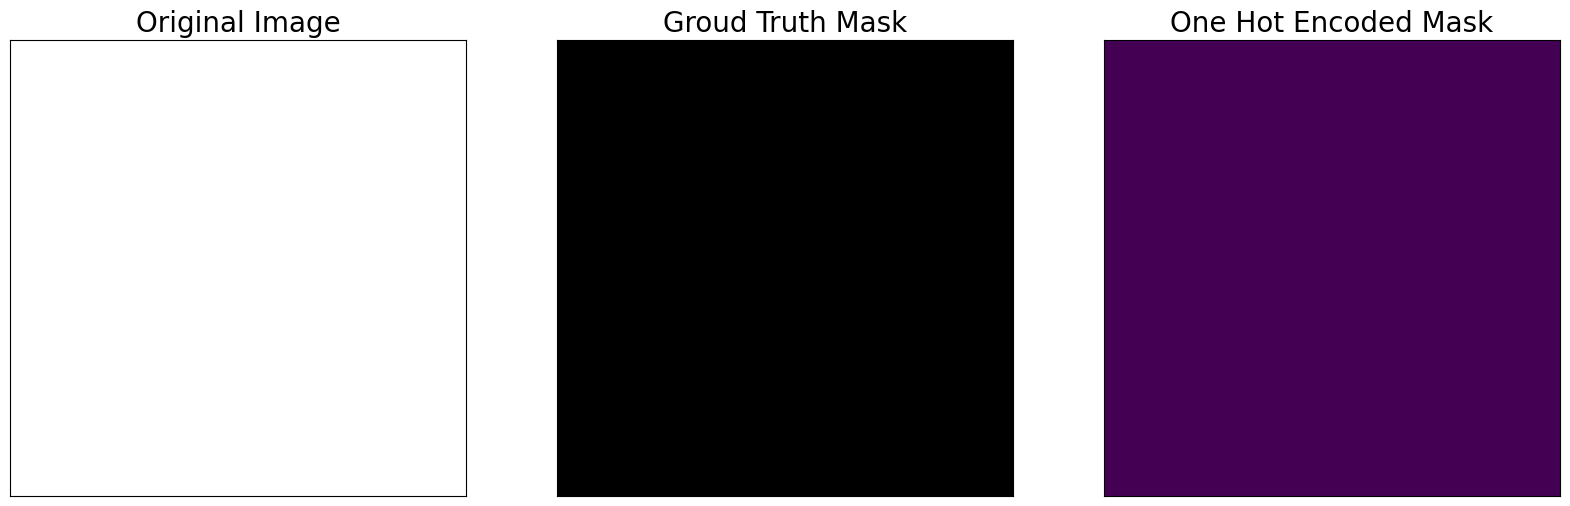

In [65]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation = get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0,len(augmented_dataset)-1)

#image/mask 쌍에 랜덤 증가 적용
for i in range(3):
    image, mask = augmented_dataset[random_idx] #랜덤하게 택 1
    visualize( #이미지 보여주기
        original_image = image,
        #역 원핫인코딩에 컬러코드 적용
        groud_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

#### 모델 정의

In [66]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),            
        )
    def forward(self, x):
        return self.double_conv(x)
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)
        
    def forward(self,x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)
    
class UpBlock(nn.Module):
    #input보다 큰 필터를 이용하여 output을 낸다
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor = 2, mode='bilinear',align_corners=True)
        else:
            raise ValueError("지원되지 않는 up_sample_mode (conv_transpose' 또는 'bilinear' 중 하나를 선택할 수 있음)")
        self.double_conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, down_input, skip_input):
        x=self.up_sample(down_input)
        x=torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)
    
class UNet(nn.Module):
    def __init__(self, out_classes = 2, up_sample_mode = 'conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        #다운샘플링
        self.down_conv1 = DownBlock(3,64)
        self.down_conv2 = DownBlock(64,128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        #병목
        self.double_conv = DoubleConv(512, 1024)
        #업샘플링
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        
        #Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        
    def forward(self, x):
        x, skip1_out = self.down_conv1(x)#conv 두번
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x,skip4_out)
        x = self.up_conv3(x,skip3_out)
        x = self.up_conv2(x,skip2_out)
        x = self.up_conv1(x,skip1_out)
        x = self.conv_last(x)
        return x
    
model = UNet()

#### Get Train/Val Dataloaders

In [67]:
#get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation = get_training_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn=None),
    class_rgb_values = select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn=None),
    class_rgb_values = select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

#### 하이퍼파라미터 설정

In [68]:
# Check for the correct import statement
from segmentation_models_pytorch import utils

**IoU(Intersetion over Union)** - 2개의 영역이 얼마나 겹쳐져 있는가?
- 정답영역과 예측영역이 겹쳐진 부분이 클수록 IoU값이 커짐

In [69]:
TRAINING = True
EPOCHS = 12
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.DiceLoss()

#매트릭스 정의
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

#옵티마이저 정의
optimizer = torch.optim.Adam([
    dict(params = model.parameters(), lr=0.00008),
])

#학습률 스케줄러 정의
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult = 2, eta_min = 5e-5,
)


In [70]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss = loss,
    metrics = metrics,
    optimizer = optimizer,
    device = DEVICE,
    verbose = True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss = loss,
    metrics = metrics,
    device = DEVICE,
    verbose = True,
)

In [71]:
# load best saved model checkpoint from previous commit (if present)
if os.path.exists('best_model.pth'):
    model = torch.load('best_model.pth', map_location=DEVICE)

#### Training UNet

In [72]:
%%time

if TRAINING:
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [],[]
    
    for i in range(0, EPOCHS):
        #Perform training & validation
        print("\nEpoch: {}".format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        
        #Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_ios_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('model saved!')


Epoch: 0
valid: 100%|███████████████████████████████████| 4/4 [01:01<00:00, 15.32s/it, dice_loss - 0.954, iou_score - 4.444e-14]
model saved!

Epoch: 1
valid: 100%|█████████████████████████████████████| 4/4 [00:57<00:00, 14.43s/it, dice_loss - 0.3516, iou_score - 0.2171]
model saved!

Epoch: 2
valid: 100%|█████████████████████████████████████| 4/4 [00:59<00:00, 14.77s/it, dice_loss - -0.574, iou_score - 0.7403]
model saved!

Epoch: 3
valid: 100%|█████████████████████████████████████| 4/4 [01:02<00:00, 15.52s/it, dice_loss - -1.129, iou_score - 0.7777]
model saved!

Epoch: 4
valid: 100%|██████████████████████████████████████| 4/4 [01:02<00:00, 15.59s/it, dice_loss - -1.288, iou_score - 0.762]
model saved!

Epoch: 5
valid: 100%|█████████████████████████████████████| 4/4 [00:58<00:00, 14.53s/it, dice_loss - -1.622, iou_score - 0.7061]
model saved!

Epoch: 6
valid: 100%|█████████████████████████████████████| 4/4 [00:56<00:00, 14.15s/it, dice_loss - -2.053, iou_score - 0.6147]
model saved!

#### 테스트 데이터 예측

In [73]:
# 베스트 체크포인트 모델을 로드한다
if os.path.exists('best_model.pth'):
    best_model = torch.load('best_model.pth', map_location = DEVICE)
    print("Loaded UNet model from this run")
#이전 커밋에서 가장 잘 저장된 모델 체크포인트 로드(있는 경우)
elif os.path.exists('../input/unet-for-building-segmentation-pytorch/best_model.pth'):
    best_model = torch.load('../input/unet-for-building-segmentation-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run


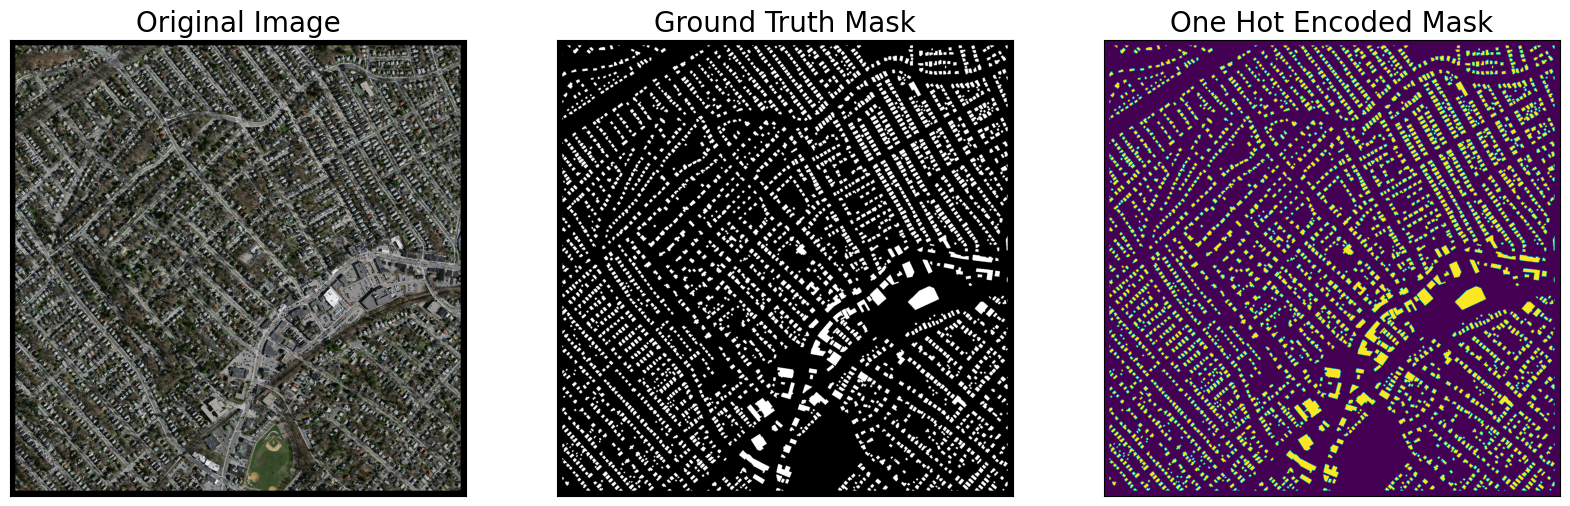

In [76]:
# UNet 모델을 이용해서 테스트 데이터로드 생성
test_dataset = BuildingsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn=None),
    class_rgb_values = select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

#시각화를 위한 테스트 데이터셋
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir,
    augmentation = get_validation_augmentation(),
    class_rgb_values = select_class_rgb_values,
)

#랜덤 이미지 마스크 인덱스를 가져온다
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)



In [77]:
# 중앙 크롭 이미지 / 원본 차원 마스크
def crop_image(image, target_image_dims = [1500, 1500, 3]):
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size)//2
    
    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [ ]:
sample_preds_folder = 'sample_prediction/s'